## Figure 9 (Journal of Climate submission; Molina et al.)

Fig. 9. ITCZ median latitude across the tropical (a) Atlantic and (b) Pacific Oceans for the CESM1 control and various experiments. The median ITCZ latitude was estimated using maximum wind convergence at 850-hPa between 15$^{\circ}$S-20$^{\circ}$N and 35$^{\circ}$W-15$^{\circ}$W for the Atlantic and between 3$^{\circ}$S-20$^{\circ}$N and 170$^{\circ}$E-90$^{\circ}$W for the Pacific.

In [1]:
import xarray as xr
import numpy as np
from scipy import ndimage, misc
from scipy.signal.signaltools import wiener
from scipy.ndimage.filters import uniform_filter1d
import matplotlib.pyplot as plt
from climatico import enso
from datetime import timedelta
import cftime
from scipy.ndimage import gaussian_filter

In [2]:
from config import directory_figs, directory_data

In [3]:
# list of filenames to do this for:

# wind stress x-direction
windu_g02sv = 'b.e11.B1850LENS.f09_g16.FWAtSalG02Sv.cam.850.U.*.nc'
windu_g04sv = 'b.e11.B1850LENS.f09_g16.FWAtSalG04Sv.cam.850.U.*.nc'
windu_p02sv = 'b.e11.B1850LENS.f09_g16.FWAtSalP02Sv.cam.850.U.*.nc'
windu_p04sv = 'b.e11.B1850LENS.f09_g16.FWAtSalP04Sv.cam.850.U.*.nc'
windu_psalt = 'b.e11.B1850LENS.f09_g16.FWPaSalP04Sv.cam.850.U.*.nc'
windu_cntrl = 'b.e11.B1850C5CN.f09_g16.005.cam.850.U.*.nc'

# wind stress y-direction
windv_g02sv = 'b.e11.B1850LENS.f09_g16.FWAtSalG02Sv.cam.850.V.*.nc'
windv_g04sv = 'b.e11.B1850LENS.f09_g16.FWAtSalG04Sv.cam.850.V.*.nc'
windv_p02sv = 'b.e11.B1850LENS.f09_g16.FWAtSalP02Sv.cam.850.V.*.nc'
windv_p04sv = 'b.e11.B1850LENS.f09_g16.FWAtSalP04Sv.cam.850.V.*.nc'
windv_psalt = 'b.e11.B1850LENS.f09_g16.FWPaSalP04Sv.cam.850.V.*.nc'
windv_cntrl = 'b.e11.B1850C5CN.f09_g16.005.cam.850.V.*.nc'

In [4]:
pac_itcz = enso.DefineNino(nino='npacitcz', lats='lat', lons='lon')
atl_itcz = enso.DefineNino(nino='atlitcz', lats='lat', lons='lon')

In [5]:
def wind_convergence(U,V):
    """
    Compute wind convergence.
    
    Args:
        U, V: u and v winds as arrays. Must be 3d (time, lat, lon).
        
    Notes:
        Method for determing shifts in ITCZ using wind convergence, from:
        https://scholarcommons.usf.edu/cgi/viewcontent.cgi?referer=https://www.google.com/&httpsredir=1&article=7842&context=etd
    """
    [du_dx, du_dy] = np.gradient(U, axis=[1,2])
    [dv_dx, dv_dy] = np.gradient(V, axis=[1,2])
    divergence = du_dx + dv_dy
    return divergence * -1

def get_itcz_matrix(U, V):
    """
    Compute estimated ITCZ position using max latitude per longitude and various smoothers for convergence noise.
    
    Args:
        U, V: u and v winds as arrays. Must be 3d (time, lat, lon).
        
    Returns:
        binary mask and binary mask with 6-month running mean.
    """
    # compute convergence, running mean filter of 3, adaptive low-pass filter -- wiener  
    tmp_itcz = wiener(ndimage.uniform_filter(wind_convergence(U, V), size=3))
    #tmp_itcz = wiener(gaussian_filter(wind_convergence(U, V), sigma=1.5))
    # grab max values
    itcz_locs = np.argmax(tmp_itcz[:,:,:],axis=1)
    # create zero array
    mask_itcz = np.zeros((tmp_itcz.shape))
    # fill itcz mask
    for time in range(tmp_itcz.shape[0]):
        for enum, i in enumerate(itcz_locs[time]):
            mask_itcz[time,i,enum] =+ 1
    # 6 mo running mean of mask
    mask_itcz_6mo = uniform_filter1d(mask_itcz, 6, axis=0)
    return mask_itcz, mask_itcz_6mo

def create_itcz_ds(mask1, mask2, time, lat, lon):
    """
    Assemble as xr.Dataset
    """
    return xr.Dataset(
               {'itcz':    (['time','lat','lon'],m_itcz),
                'itcz_6mo':(['time','lat','lon'],m_itcz_6mo)},
               coords={
                   'time':(['time'],time),
                   'lat':(['lat'],lat),
                   'lon':(['lon'],lon)})

In [6]:
u_pac = xr.open_mfdataset(f'{directory_data}{windu_g02sv}', preprocess=pac_itcz.nino).isel(plev=0)['U'].fillna(0.0)
u_pac = u_pac.assign_coords(time=u_pac.coords['time'] - timedelta(days=17))
u_pac = u_pac.sel(time=slice(cftime.DatetimeNoLeap(1, 1, 1, 0, 0),cftime.DatetimeNoLeap(801, 1, 1, 0, 0)))

lat_pac = u_pac.coords['lat']
lon_pac = u_pac.coords['lon']
time_pac = u_pac.coords['time']
u_pac = u_pac.values

v_pac = xr.open_mfdataset(f'{directory_data}{windv_g02sv}', preprocess=pac_itcz.nino).isel(plev=0)['V'].fillna(0.0)
v_pac = v_pac.assign_coords(time=v_pac.coords['time'] - timedelta(days=17))
v_pac = v_pac.sel(time=slice(cftime.DatetimeNoLeap(1, 1, 1, 0, 0),cftime.DatetimeNoLeap(801, 1, 1, 0, 0)))
v_pac = v_pac.values

m_itcz, m_itcz_6mo = get_itcz_matrix(u_pac, v_pac)
ds_itcz_pac_g02sv = create_itcz_ds(m_itcz, m_itcz_6mo, time_pac, lat_pac, lon_pac)

#ds_itcz_pac_g02sv.mean('time')['itcz'].plot.pcolormesh(); plt.show()
#ds_itcz_pac_g02sv['itcz'].idxmax('lat').median('lon').resample(time='AS').mean().plot(); plt.show()
#ds_itcz_pac_g02sv['itcz'].idxmax('lat').median('lon').resample(time='AS').mean().rolling(time=30).mean().plot(); plt.show()

In [7]:
u_pac = xr.open_mfdataset(f'{directory_data}{windu_g04sv}', preprocess=pac_itcz.nino).isel(plev=0)['U'].fillna(0.0)
u_pac = u_pac.assign_coords(time=u_pac.coords['time'] - timedelta(days=17))
u_pac = u_pac.sel(time=slice(cftime.DatetimeNoLeap(1, 1, 1, 0, 0),cftime.DatetimeNoLeap(801, 1, 1, 0, 0)))

lat_pac = u_pac.coords['lat']
lon_pac = u_pac.coords['lon']
time_pac = u_pac.coords['time']
u_pac = u_pac.values

v_pac = xr.open_mfdataset(f'{directory_data}{windv_g04sv}', preprocess=pac_itcz.nino).isel(plev=0)['V'].fillna(0.0)
v_pac = v_pac.assign_coords(time=v_pac.coords['time'] - timedelta(days=17))
v_pac = v_pac.sel(time=slice(cftime.DatetimeNoLeap(1, 1, 1, 0, 0),cftime.DatetimeNoLeap(801, 1, 1, 0, 0)))
v_pac = v_pac.values

m_itcz, m_itcz_6mo = get_itcz_matrix(u_pac, v_pac)
ds_itcz_pac_g04sv = create_itcz_ds(m_itcz, m_itcz_6mo, time_pac, lat_pac, lon_pac)

#ds_itcz_pac_g04sv.mean('time')['itcz'].plot.pcolormesh(); plt.show()
#ds_itcz_pac_g04sv['itcz'].idxmax('lat').median('lon').resample(time='AS').mean().rolling(time=30).mean().plot(); plt.show()

In [8]:
u_pac = xr.open_mfdataset(f'{directory_data}{windu_p02sv}', preprocess=pac_itcz.nino).isel(plev=0)['U'].fillna(0.0)
u_pac = u_pac.assign_coords(time=u_pac.coords['time'] - timedelta(days=17))
u_pac = u_pac.sel(time=slice(cftime.DatetimeNoLeap(1, 1, 1, 0, 0),cftime.DatetimeNoLeap(801, 1, 1, 0, 0)))

lat_pac = u_pac.coords['lat']
lon_pac = u_pac.coords['lon']
time_pac = u_pac.coords['time']
u_pac = u_pac.values

v_pac = xr.open_mfdataset(f'{directory_data}{windv_p02sv}', preprocess=pac_itcz.nino).isel(plev=0)['V'].fillna(0.0)
v_pac = v_pac.assign_coords(time=v_pac.coords['time'] - timedelta(days=17))
v_pac = v_pac.sel(time=slice(cftime.DatetimeNoLeap(1, 1, 1, 0, 0),cftime.DatetimeNoLeap(801, 1, 1, 0, 0)))
v_pac = v_pac.values

m_itcz, m_itcz_6mo = get_itcz_matrix(u_pac, v_pac)
ds_itcz_pac_p02sv = create_itcz_ds(m_itcz, m_itcz_6mo, time_pac, lat_pac, lon_pac)

#ds_itcz_pac_p02sv.mean('time')['itcz'].plot.pcolormesh(); plt.show()
#ds_itcz_pac_p02sv['itcz'].idxmax('lat').median('lon').resample(time='AS').mean().rolling(time=30).mean().plot(); plt.show()

In [9]:
u_pac = xr.open_mfdataset(f'{directory_data}{windu_p04sv}', preprocess=pac_itcz.nino).isel(plev=0)['U'].fillna(0.0)
u_pac = u_pac.assign_coords(time=u_pac.coords['time'] - timedelta(days=17))
u_pac = u_pac.sel(time=slice(cftime.DatetimeNoLeap(1, 1, 1, 0, 0),cftime.DatetimeNoLeap(801, 1, 1, 0, 0)))

lat_pac = u_pac.coords['lat']
lon_pac = u_pac.coords['lon']
time_pac = u_pac.coords['time']
u_pac = u_pac.values

v_pac = xr.open_mfdataset(f'{directory_data}{windv_p04sv}', preprocess=pac_itcz.nino).isel(plev=0)['V'].fillna(0.0)
v_pac = v_pac.assign_coords(time=v_pac.coords['time'] - timedelta(days=17))
v_pac = v_pac.sel(time=slice(cftime.DatetimeNoLeap(1, 1, 1, 0, 0),cftime.DatetimeNoLeap(801, 1, 1, 0, 0)))
v_pac = v_pac.values

m_itcz, m_itcz_6mo = get_itcz_matrix(u_pac, v_pac)
ds_itcz_pac_p04sv = create_itcz_ds(m_itcz, m_itcz_6mo, time_pac, lat_pac, lon_pac)

#ds_itcz_pac_p04sv.mean('time')['itcz'].plot.pcolormesh(); plt.show()
#ds_itcz_pac_p04sv['itcz'].idxmax('lat').median('lon').resample(time='AS').mean().rolling(time=30).mean().plot(); plt.show()

In [10]:
u_pac = xr.open_mfdataset(f'{directory_data}{windu_psalt}', preprocess=pac_itcz.nino).isel(plev=0)['U'].fillna(0.0)
u_pac = u_pac.assign_coords(time=u_pac.coords['time'] - timedelta(days=17))
u_pac = u_pac.sel(time=slice(cftime.DatetimeNoLeap(1, 1, 1, 0, 0),cftime.DatetimeNoLeap(351, 1, 1, 0, 0)))

lat_pac = u_pac.coords['lat']
lon_pac = u_pac.coords['lon']
time_pac = u_pac.coords['time']
u_pac = u_pac.values

v_pac = xr.open_mfdataset(f'{directory_data}{windv_psalt}', preprocess=pac_itcz.nino).isel(plev=0)['V'].fillna(0.0)
v_pac = v_pac.assign_coords(time=v_pac.coords['time'] - timedelta(days=17))
v_pac = v_pac.sel(time=slice(cftime.DatetimeNoLeap(1, 1, 1, 0, 0),cftime.DatetimeNoLeap(351, 1, 1, 0, 0)))
v_pac = v_pac.values

m_itcz, m_itcz_6mo = get_itcz_matrix(u_pac, v_pac)
ds_itcz_pac_psalt = create_itcz_ds(m_itcz, m_itcz_6mo, time_pac, lat_pac, lon_pac)

#ds_itcz_pac_psalt.mean('time')['itcz'].plot.pcolormesh(); plt.show()
#ds_itcz_pac_psalt['itcz'].idxmax('lat').median('lon').resample(time='AS').mean().rolling(time=30).mean().plot(); plt.show()

In [11]:
u_pac = xr.open_mfdataset(f'{directory_data}{windu_cntrl}', preprocess=pac_itcz.nino).isel(plev=0)['U'].fillna(0.0)
u_pac = u_pac.assign_coords(time=u_pac.coords['time'] - timedelta(days=17))
u_pac = u_pac.sel(time=slice(cftime.DatetimeNoLeap(800, 1, 1, 0, 0),cftime.DatetimeNoLeap(1600, 1, 1, 0, 0)))

lat_pac = u_pac.coords['lat']
lon_pac = u_pac.coords['lon']
time_pac = u_pac.coords['time']
u_pac = u_pac.values

v_pac = xr.open_mfdataset(f'{directory_data}{windv_cntrl}', preprocess=pac_itcz.nino).isel(plev=0)['V'].fillna(0.0)
v_pac = v_pac.assign_coords(time=v_pac.coords['time'] - timedelta(days=17))
v_pac = v_pac.sel(time=slice(cftime.DatetimeNoLeap(800, 1, 1, 0, 0),cftime.DatetimeNoLeap(1600, 1, 1, 0, 0)))
v_pac = v_pac.values

m_itcz, m_itcz_6mo = get_itcz_matrix(u_pac, v_pac)
ds_itcz_pac_cntrl = create_itcz_ds(m_itcz, m_itcz_6mo, time_pac, lat_pac, lon_pac)

#ds_itcz_pac_cntrl.mean('time')['itcz'].plot.pcolormesh(); plt.show()
#ds_itcz_pac_cntrl['itcz'].idxmax('lat').median('lon').resample(time='AS').mean().rolling(time=30).mean().plot(); plt.show()

In [12]:
u_atl = xr.open_mfdataset(f'{directory_data}{windu_g02sv}', preprocess=atl_itcz.nino).isel(plev=0)['U'].fillna(0.0)
u_atl = u_atl.assign_coords(time=u_atl.coords['time'] - timedelta(days=17))
u_atl = u_atl.sel(time=slice(cftime.DatetimeNoLeap(1, 1, 1, 0, 0),cftime.DatetimeNoLeap(801, 1, 1, 0, 0)))

lat_atl = u_atl.coords['lat']
lon_atl = u_atl.coords['lon']
time_atl = u_atl.coords['time']
u_atl = u_atl.values

v_atl = xr.open_mfdataset(f'{directory_data}{windv_g02sv}', preprocess=atl_itcz.nino).isel(plev=0)['V'].fillna(0.0)
v_atl = v_atl.assign_coords(time=v_atl.coords['time'] - timedelta(days=17))
v_atl = v_atl.sel(time=slice(cftime.DatetimeNoLeap(1, 1, 1, 0, 0),cftime.DatetimeNoLeap(801, 1, 1, 0, 0)))
v_atl = v_atl.values

m_itcz, m_itcz_6mo = get_itcz_matrix(u_atl, v_atl)
ds_itcz_atl_g02sv = create_itcz_ds(m_itcz, m_itcz_6mo, time_atl, lat_atl, lon_atl)

#ds_itcz_atl_g02sv.mean('time')['itcz'].plot.pcolormesh(); plt.show()
#ds_itcz_atl_g02sv['itcz'].idxmax('lat').median('lon').resample(time='AS').mean().rolling(time=30).mean().plot(); plt.show()

In [13]:
u_atl = xr.open_mfdataset(f'{directory_data}{windu_g04sv}', preprocess=atl_itcz.nino).isel(plev=0)['U'].fillna(0.0)
u_atl = u_atl.assign_coords(time=u_atl.coords['time'] - timedelta(days=17))
u_atl = u_atl.sel(time=slice(cftime.DatetimeNoLeap(1, 1, 1, 0, 0),cftime.DatetimeNoLeap(801, 1, 1, 0, 0)))

lat_atl = u_atl.coords['lat']
lon_atl = u_atl.coords['lon']
time_atl = u_atl.coords['time']
u_atl = u_atl.values

v_atl = xr.open_mfdataset(f'{directory_data}{windv_g04sv}', preprocess=atl_itcz.nino).isel(plev=0)['V'].fillna(0.0)
v_atl = v_atl.assign_coords(time=v_atl.coords['time'] - timedelta(days=17))
v_atl = v_atl.sel(time=slice(cftime.DatetimeNoLeap(1, 1, 1, 0, 0),cftime.DatetimeNoLeap(801, 1, 1, 0, 0)))
v_atl = v_atl.values

m_itcz, m_itcz_6mo = get_itcz_matrix(u_atl, v_atl)
ds_itcz_atl_g04sv = create_itcz_ds(m_itcz, m_itcz_6mo, time_atl, lat_atl, lon_atl)

#ds_itcz_atl_g04sv.mean('time')['itcz'].plot.pcolormesh(); plt.show()
#ds_itcz_atl_g04sv['itcz'].idxmax('lat').median('lon').resample(time='AS').mean().rolling(time=30).mean().plot(); plt.show()

In [14]:
u_atl = xr.open_mfdataset(f'{directory_data}{windu_p02sv}', preprocess=atl_itcz.nino).isel(plev=0)['U'].fillna(0.0)
u_atl = u_atl.assign_coords(time=u_atl.coords['time'] - timedelta(days=17))
u_atl = u_atl.sel(time=slice(cftime.DatetimeNoLeap(1, 1, 1, 0, 0),cftime.DatetimeNoLeap(801, 1, 1, 0, 0)))

lat_atl = u_atl.coords['lat']
lon_atl = u_atl.coords['lon']
time_atl = u_atl.coords['time']
u_atl = u_atl.values

v_atl = xr.open_mfdataset(f'{directory_data}{windv_p02sv}', preprocess=atl_itcz.nino).isel(plev=0)['V'].fillna(0.0)
v_atl = v_atl.assign_coords(time=v_atl.coords['time'] - timedelta(days=17))
v_atl = v_atl.sel(time=slice(cftime.DatetimeNoLeap(1, 1, 1, 0, 0),cftime.DatetimeNoLeap(801, 1, 1, 0, 0)))
v_atl = v_atl.values

m_itcz, m_itcz_6mo = get_itcz_matrix(u_atl, v_atl)
ds_itcz_atl_p02sv = create_itcz_ds(m_itcz, m_itcz_6mo, time_atl, lat_atl, lon_atl)

#ds_itcz_atl_p02sv.mean('time')['itcz'].plot.pcolormesh(); plt.show()
#ds_itcz_atl_p02sv['itcz'].idxmax('lat').median('lon').resample(time='AS').mean().rolling(time=30).mean().plot(); plt.show()

In [15]:
u_atl = xr.open_mfdataset(f'{directory_data}{windu_p04sv}', preprocess=atl_itcz.nino).isel(plev=0)['U'].fillna(0.0)
u_atl = u_atl.assign_coords(time=u_atl.coords['time'] - timedelta(days=17))
u_atl = u_atl.sel(time=slice(cftime.DatetimeNoLeap(1, 1, 1, 0, 0),cftime.DatetimeNoLeap(801, 1, 1, 0, 0)))

lat_atl = u_atl.coords['lat']
lon_atl = u_atl.coords['lon']
time_atl = u_atl.coords['time']
u_atl = u_atl.values

v_atl = xr.open_mfdataset(f'{directory_data}{windv_p04sv}', preprocess=atl_itcz.nino).isel(plev=0)['V'].fillna(0.0)
v_atl = v_atl.assign_coords(time=v_atl.coords['time'] - timedelta(days=17))
v_atl = v_atl.sel(time=slice(cftime.DatetimeNoLeap(1, 1, 1, 0, 0),cftime.DatetimeNoLeap(801, 1, 1, 0, 0)))
v_atl = v_atl.values

m_itcz, m_itcz_6mo = get_itcz_matrix(u_atl, v_atl)
ds_itcz_atl_p04sv = create_itcz_ds(m_itcz, m_itcz_6mo, time_atl, lat_atl, lon_atl)

#ds_itcz_atl_p04sv.mean('time')['itcz'].plot.pcolormesh(); plt.show()
#ds_itcz_atl_p04sv['itcz'].idxmax('lat').median('lon').resample(time='AS').mean().rolling(time=30).mean().plot(); plt.show()

In [16]:
u_atl = xr.open_mfdataset(f'{directory_data}{windu_psalt}', preprocess=atl_itcz.nino).isel(plev=0)['U'].fillna(0.0)
u_atl = u_atl.assign_coords(time=u_atl.coords['time'] - timedelta(days=17))
u_atl = u_atl.sel(time=slice(cftime.DatetimeNoLeap(1, 1, 1, 0, 0),cftime.DatetimeNoLeap(351, 1, 1, 0, 0)))

lat_atl = u_atl.coords['lat']
lon_atl = u_atl.coords['lon']
time_atl = u_atl.coords['time']
u_atl = u_atl.values

v_atl = xr.open_mfdataset(f'{directory_data}{windv_psalt}', preprocess=atl_itcz.nino).isel(plev=0)['V'].fillna(0.0)
v_atl = v_atl.assign_coords(time=v_atl.coords['time'] - timedelta(days=17))
v_atl = v_atl.sel(time=slice(cftime.DatetimeNoLeap(1, 1, 1, 0, 0),cftime.DatetimeNoLeap(351, 1, 1, 0, 0)))
v_atl = v_atl.values

m_itcz, m_itcz_6mo = get_itcz_matrix(u_atl, v_atl)
ds_itcz_atl_psalt = create_itcz_ds(m_itcz, m_itcz_6mo, time_atl, lat_atl, lon_atl)

#ds_itcz_atl_psalt.mean('time')['itcz'].plot.pcolormesh(); plt.show()
#ds_itcz_atl_psalt['itcz'].idxmax('lat').median('lon').resample(time='AS').mean().rolling(time=30).mean().plot(); plt.show()

In [17]:
u_atl = xr.open_mfdataset(f'{directory_data}{windu_cntrl}', preprocess=atl_itcz.nino).isel(plev=0)['U'].fillna(0.0)
u_atl = u_atl.assign_coords(time=u_atl.coords['time'] - timedelta(days=17))
u_atl = u_atl.sel(time=slice(cftime.DatetimeNoLeap(800, 1, 1, 0, 0),cftime.DatetimeNoLeap(1600, 1, 1, 0, 0)))

lat_atl = u_atl.coords['lat']
lon_atl = u_atl.coords['lon']
time_atl = u_atl.coords['time']
u_atl = u_atl.values

v_atl = xr.open_mfdataset(f'{directory_data}{windv_cntrl}', preprocess=atl_itcz.nino).isel(plev=0)['V'].fillna(0.0)
v_atl = v_atl.assign_coords(time=v_atl.coords['time'] - timedelta(days=17))
v_atl = v_atl.sel(time=slice(cftime.DatetimeNoLeap(800, 1, 1, 0, 0),cftime.DatetimeNoLeap(1600, 1, 1, 0, 0)))
v_atl = v_atl.values

m_itcz, m_itcz_6mo = get_itcz_matrix(u_atl, v_atl)
ds_itcz_atl_cntrl = create_itcz_ds(m_itcz, m_itcz_6mo, time_atl, lat_atl, lon_atl)

#ds_itcz_atl_cntrl.mean('time')['itcz'].plot.pcolormesh(); plt.show()
#ds_itcz_atl_cntrl['itcz'].idxmax('lat').median('lon').resample(time='AS').mean().rolling(time=30).mean().plot(); plt.show()

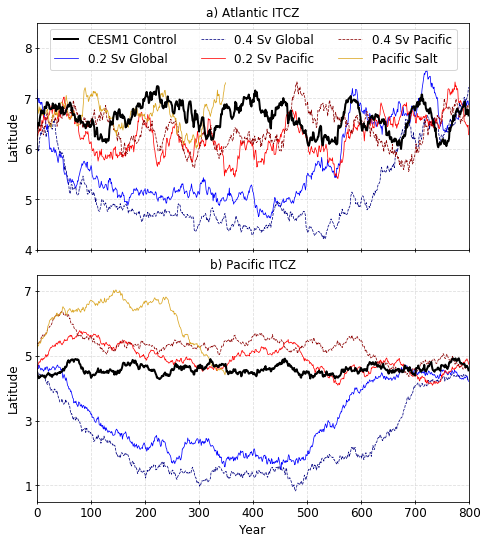

In [18]:
# -------------- create figure

a = u"\u00b0"

fig = plt.figure(figsize=(6,7))

# --------------

ax1 = plt.axes([0., 0.5, 1., 0.45])

ax1.set_title('a) Atlantic ITCZ', fontsize=12)

l1, = ax1.plot(ds_itcz_atl_cntrl['itcz'].idxmax('lat').median('lon').resample(time='AS').mean().rolling(time=30,min_periods=1,center=True).mean(),
               c='k', alpha=1.0, lw=2., zorder=5)

l2, = ax1.plot(ds_itcz_atl_g02sv['itcz'].idxmax('lat').median('lon').resample(time='AS').mean().rolling(time=30,min_periods=1,center=True).mean(),
               c='blue', alpha=1.0, lw=0.75, zorder=2)
l3, = ax1.plot(ds_itcz_atl_g04sv['itcz'].idxmax('lat').median('lon').resample(time='AS').mean().rolling(time=30,min_periods=1,center=True).mean(), 
               c='navy', alpha=1.0, ls='--', lw=0.75, zorder=2)
l4, = ax1.plot(ds_itcz_atl_p02sv['itcz'].idxmax('lat').median('lon').resample(time='AS').mean().rolling(time=30,min_periods=1,center=True).mean(), 
               c='red', alpha=1.0, lw=0.75, zorder=2)
l5, = ax1.plot(ds_itcz_atl_p04sv['itcz'].idxmax('lat').median('lon').resample(time='AS').mean().rolling(time=30,min_periods=1,center=True).mean(), 
               c='darkred', alpha=1.0, ls='--', lw=0.75, zorder=2)
l6, = ax1.plot(ds_itcz_atl_psalt['itcz'].idxmax('lat').median('lon').resample(time='AS').mean().rolling(time=30,min_periods=1,center=True).mean(), 
               c='goldenrod', alpha=1.0, lw=0.75, zorder=2)

ax1.margins(x=0)
ax1.set_xlim([0,800])
ax1.set_ylim([4,8.5])

ax1.tick_params(axis='both', labelleft=True, direction='inout', labelbottom=False, labelsize=12)
ax1.grid(alpha=0.4, ls='--')

ax1.set_ylabel(r'Latitude', fontsize=12)
ax1.set_yticks([4,5,6,7,8])
ax1.set_yticklabels([4,5,6,7,8])

# --------------

ax2 = plt.axes([0., 0., 1., 0.45])

ax2.set_title('b) Pacific ITCZ', fontsize=12)

l1, = ax2.plot(ds_itcz_pac_cntrl['itcz'].idxmax('lat').median('lon').resample(time='AS').mean().rolling(time=30,min_periods=1,center=True).mean(),
               c='k', alpha=1.0, lw=2., zorder=5)

l2, = ax2.plot(ds_itcz_pac_g02sv['itcz'].idxmax('lat').median('lon').resample(time='AS').mean().rolling(time=30,min_periods=1,center=True).mean(),
               c='blue', alpha=1.0, lw=0.75, zorder=2)
l3, = ax2.plot(ds_itcz_pac_g04sv['itcz'].idxmax('lat').median('lon').resample(time='AS').mean().rolling(time=30,min_periods=1,center=True).mean(), 
               c='navy', alpha=1.0, ls='--', lw=0.75, zorder=2)
l4, = ax2.plot(ds_itcz_pac_p02sv['itcz'].idxmax('lat').median('lon').resample(time='AS').mean().rolling(time=30,min_periods=1,center=True).mean(), 
               c='red', alpha=1.0, lw=0.75, zorder=2)
l5, = ax2.plot(ds_itcz_pac_p04sv['itcz'].idxmax('lat').median('lon').resample(time='AS').mean().rolling(time=30,min_periods=1,center=True).mean(), 
               c='darkred', alpha=1.0, ls='--', lw=0.75, zorder=2)
l6, = ax2.plot(ds_itcz_pac_psalt['itcz'].idxmax('lat').median('lon').resample(time='AS').mean().rolling(time=30,min_periods=1,center=True).mean(), 
               c='goldenrod', alpha=1.0, lw=0.75, zorder=2)

ax2.margins(x=0)
ax2.set_xlim([0,800])
ax2.set_ylim([0.5,7.5])

ax2.tick_params(axis='both', labelleft=True, direction='inout', labelbottom=True, labelsize=12)
ax2.grid(alpha=0.4, ls='--')

ax2.set_ylabel(r'Latitude', fontsize=12)
ax2.set_xlabel(r'Year', fontsize=12)

ax2.set_yticks([1,3,5,7])
ax2.set_yticklabels([1,3,5,7])


# --------------


ax1.legend([l1,l2,l3,l4,l5,l6], 
           ['CESM1 Control', 
            '0.2 Sv Global',
            '0.4 Sv Global',
            '0.2 Sv Pacific',
            '0.4 Sv Pacific',
            'Pacific Salt'],
            fontsize=12, ncol=3, 
            loc='upper center')


# --------------

plt.savefig(f'{directory_figs}amocenso_fig9.png', bbox_inches='tight', dpi=200)
plt.savefig(f'{directory_figs}amocenso_fig9.pdf', bbox_inches='tight', dpi=500)
plt.show()

# --------------